<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#实验说明" data-toc-modified-id="实验说明-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>实验说明</a></span></li><li><span><a href="#数据说明" data-toc-modified-id="数据说明-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>数据说明</a></span><ul class="toc-item"><li><span><a href="#数据集说明" data-toc-modified-id="数据集说明-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>数据集说明</a></span></li><li><span><a href="#数据处理" data-toc-modified-id="数据处理-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>数据处理</a></span></li></ul></li><li><span><a href="#代码实现" data-toc-modified-id="代码实现-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>代码实现</a></span><ul class="toc-item"><li><span><a href="#CART实现手手写识别" data-toc-modified-id="CART实现手手写识别-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>CART实现手手写识别</a></span></li><li><span><a href="#AdaBoost实现手写识别" data-toc-modified-id="AdaBoost实现手写识别-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>AdaBoost实现手写识别</a></span><ul class="toc-item"><li><span><a href="#结果统计与分析" data-toc-modified-id="结果统计与分析-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>结果统计与分析</a></span></li></ul></li></ul></li><li><span><a href="#参考文献" data-toc-modified-id="参考文献-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>参考文献</a></span></li></ul></div>

# 实验说明

本实验基于`sklearn`中的分类器实现数字识别，数据来源于[GitHub](https://github.com/Asia-Lee/KNN/)。数字资源不需要特殊处理，可直接使用，便于初学者使用。
# 数据说明

  ## 数据集说明
  需要识别的数字已经使用图形处理软件，处理成具有相同的色彩和大小：宽高是32像素x32像素的黑白图像。尽管采用本文格式存储图像不能有效地利用内存空间，但是为了方便理解，在数据存储式任然保存为文本格式，对于初学者而言，有利于实验的进行，在掌握算法原理之后就能将这个模型进行扩展，添加其他的模块，如图像处理模块、数据分析模块等。

  数据集中的所有数据均能从实验说明中的[GitHub](https://github.com/Asia-Lee/KNN/)中获取，这些文本格式存储的数字的文件命名也很有特点，格式为：数字的值_该数字的样本序号。
  
  ## 数据处理
  每一个样本的数据不能做为矩阵输入，应将每个数字文件中32\*32的二进制图像矩阵转换为1*1024的向量，作为一个样本输入。随后就能使用分类器进行分类。

# 代码实现

In [1]:
import numpy as np
from skimage import io
from os import listdir
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

In [2]:
"""
function :将32x32的二进制图像转换为1x1024向量
Parament:
    filename : 文件名
Return:
    returnVect : 1 * 1024的向量
"""
def img2vector(filename):
    #创建1x1024零向量
    returnVect = np.zeros((1, 1024))
    #打开文件
    fr = open(filename)
    #按行读取
    for i in range(32):
        #读一行数据
        lineStr = fr.readline()
        #每一行的前32个元素依次添加到returnVect中
        for j in range(32):
            returnVect[0, 32*i+j] = int(lineStr[j])
    #返回转换后的1x1024向量
    return returnVect

In [3]:
'''
function : 读取fileName指定的文件夹，并显示为图像
Parament:
    fileName : 需要显示为图像的文件名    
'''
def ShowTxtPicture(fileName):
    image = np.zeros((32, 32))
    fr = open(fileName) 
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            image[i,j] = int(lineStr[j])

    plt.figure("Image")
    # 这里必须加 cmap='gray' ,否则尽管原图像是灰度图（下图1），但是显示的是伪彩色图像（下图2）（如果不加的话）
    plt.imshow(image,cmap='gray')
    plt.axis('on')
    plt.title('image')
    plt.show()

In [4]:
'''
function : 返回手写识别的训练数据与训练标签
'''
def getTrainDataWithLabel():
    #训练集的Labels
    hwLabels = []
    #返回trainingDigits目录下的文件名
    trainingFileList = listdir('./KNN-master/trainingDigits')
    #返回文件夹下文件的个数
    m = len(trainingFileList)
    #初始化训练的Mat矩阵,训练集
    trainingMat = np.zeros((m, 1024))
    #从文件名中解析出训练集的类别
    for i in range(m):
        #获得文件的名字
        fileNameStr = trainingFileList[i]
        #获得分类的数字
        classNumber = int(fileNameStr.split('_')[0])
        #将获得的类别添加到hwLabels中
        hwLabels.append(classNumber)
        #将每一个文件的1x1024数据存储到trainingMat矩阵中
        trainingMat[i,:] = img2vector('./KNN-master/trainingDigits/%s' % (fileNameStr))
    return trainingMat, hwLabels

In [5]:
'''
function : 显示分类器的错误预测结果， 并输出正确的结结果用于对比
Parament:
    classifier : 分类器   
'''
def ShowPredict(classifier):
    # 返回testDigits目录下的文件列表
    testFileList = listdir('./KNN-master/testDigits')
    # 错误检测计数
    errorCount = 0.0
    # 测试数据的数量
    mTest = len(testFileList)
    # 从文件中解析出测试集的类别并进行 分类测试
    for i in range(mTest):
        fileNameStr = testFileList[i] # 获得文件的名字
        classNumber = int(fileNameStr.split('_')[0]) # 获得分类的数字
        #获得测试集的1x1024向量,用于训练
        vectorUnderTest = img2vector('./KNN-master/testDigits/%s' % (fileNameStr))
        #获得预测结果
        classifierResult = classifier.predict(vectorUnderTest)
        # print("分类返回结果为%d\t真实结果为%d" % (classifierResult, classNumber))
        if(classifierResult != classNumber):
            ShowTxtPicture('./KNN-master/testDigits/%s' % (fileNameStr))
            print("预测为：", classifierResult,  "文件名为 ： ", fileNameStr )            
            errorCount += 1.0
    print("总共错了%d个数据\n错误率为%f%%" % (errorCount, errorCount/mTest * 100))

## CART实现手手写识别

In [6]:
"""
function :手写数字分类测试
"""
def handwritingClassTestByCART():
    trainingMat, hwLabels = getTrainDataWithLabel()
    
    #构建决策树分类器
    DecTree = DecisionTreeClassifier(criterion = 'gini', max_depth=6)
    # 拟合模型, trainingMat为训练矩阵,hwLabels为对应的标签
    DecTree.fit(trainingMat, hwLabels)
    
    ShowPredict(DecTree)

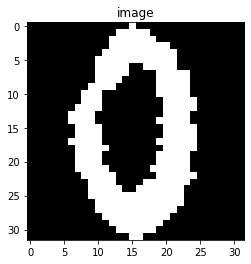

预测为： [6] 文件名为 ：  0_21.txt


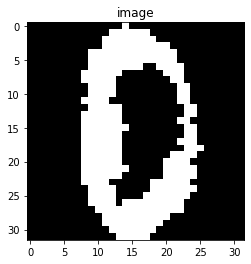

预测为： [6] 文件名为 ：  0_63.txt


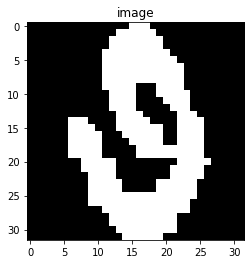

预测为： [4] 文件名为 ：  0_84.txt


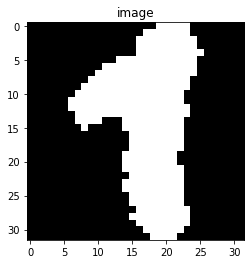

预测为： [9] 文件名为 ：  1_10.txt


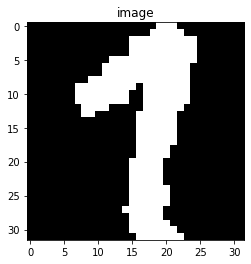

预测为： [9] 文件名为 ：  1_13.txt


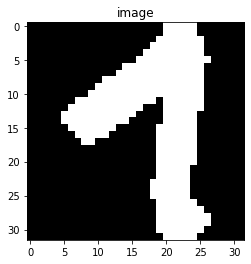

预测为： [9] 文件名为 ：  1_16.txt


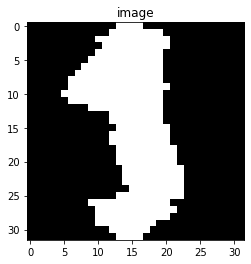

预测为： [5] 文件名为 ：  1_18.txt


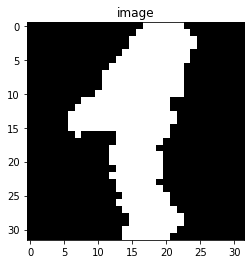

预测为： [9] 文件名为 ：  1_25.txt


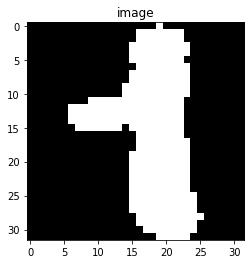

预测为： [9] 文件名为 ：  1_27.txt


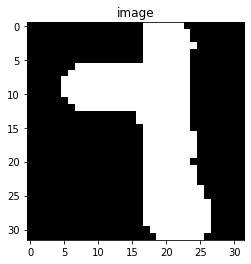

预测为： [9] 文件名为 ：  1_28.txt


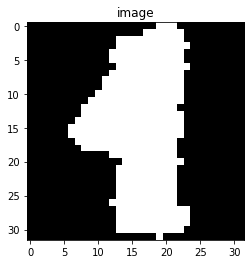

预测为： [9] 文件名为 ：  1_3.txt


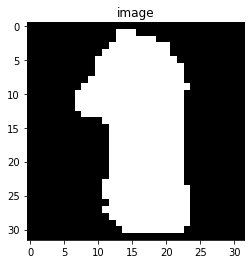

预测为： [8] 文件名为 ：  1_42.txt


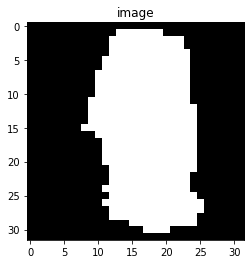

预测为： [8] 文件名为 ：  1_45.txt


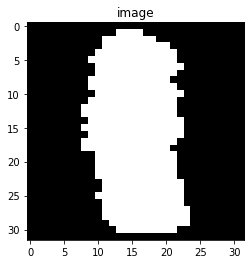

预测为： [8] 文件名为 ：  1_46.txt


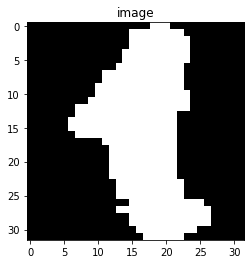

预测为： [8] 文件名为 ：  1_5.txt


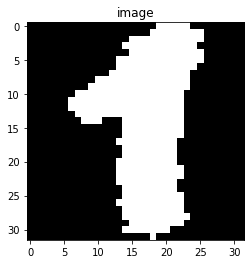

预测为： [9] 文件名为 ：  1_51.txt


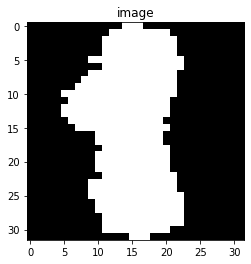

预测为： [5] 文件名为 ：  1_54.txt


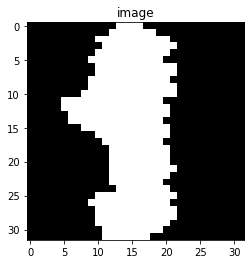

预测为： [5] 文件名为 ：  1_55.txt


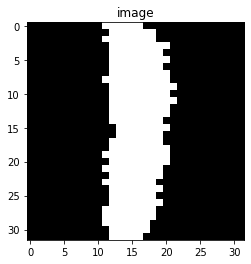

预测为： [7] 文件名为 ：  1_71.txt


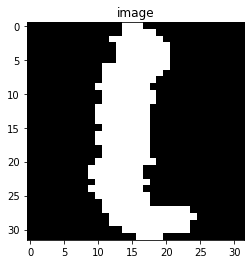

预测为： [6] 文件名为 ：  1_73.txt


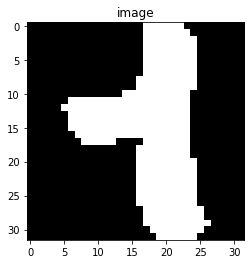

预测为： [9] 文件名为 ：  1_76.txt


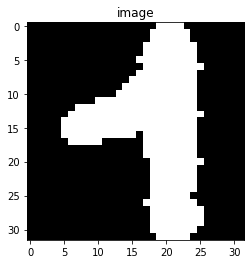

预测为： [9] 文件名为 ：  1_78.txt


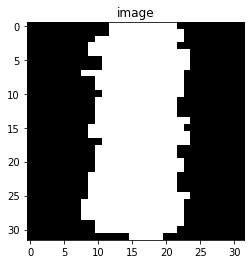

预测为： [8] 文件名为 ：  1_79.txt


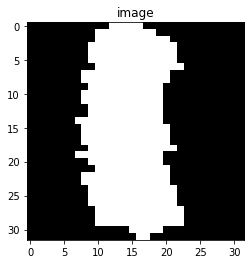

预测为： [5] 文件名为 ：  1_8.txt


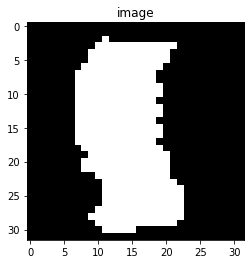

预测为： [6] 文件名为 ：  1_80.txt


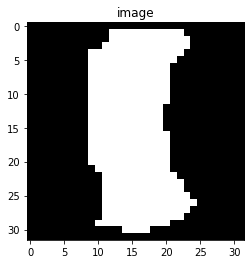

预测为： [5] 文件名为 ：  1_81.txt


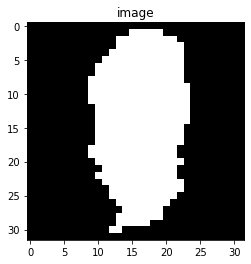

预测为： [8] 文件名为 ：  1_82.txt


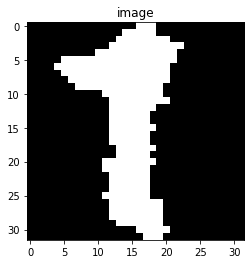

预测为： [2] 文件名为 ：  1_87.txt


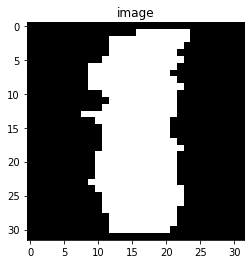

预测为： [2] 文件名为 ：  1_88.txt


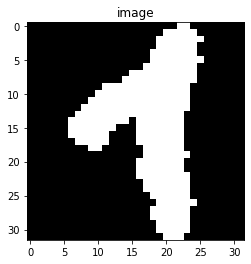

预测为： [9] 文件名为 ：  1_9.txt


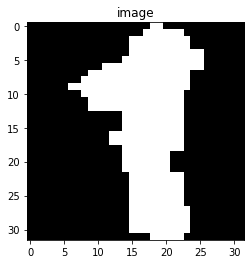

预测为： [9] 文件名为 ：  1_91.txt


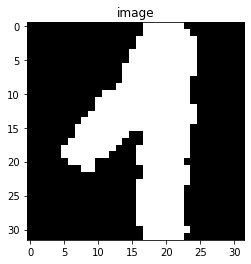

预测为： [4] 文件名为 ：  1_95.txt


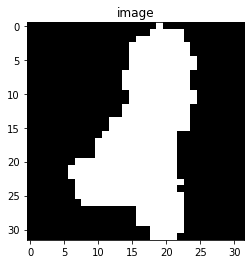

预测为： [2] 文件名为 ：  1_96.txt


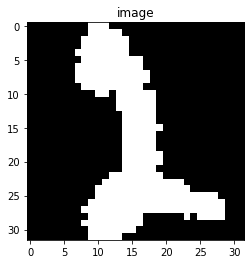

预测为： [1] 文件名为 ：  2_27.txt


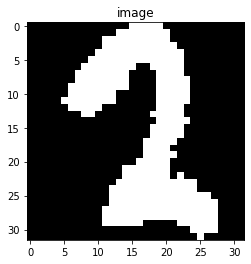

预测为： [9] 文件名为 ：  2_36.txt


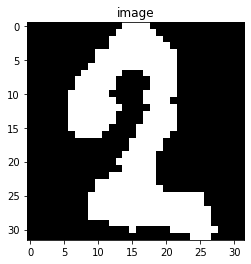

预测为： [8] 文件名为 ：  2_38.txt


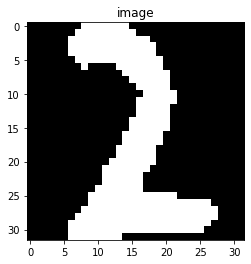

预测为： [1] 文件名为 ：  2_41.txt


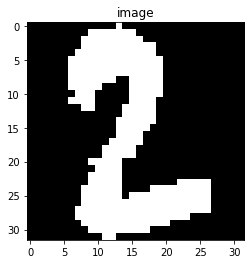

预测为： [3] 文件名为 ：  2_46.txt


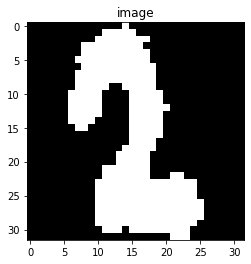

预测为： [5] 文件名为 ：  2_52.txt


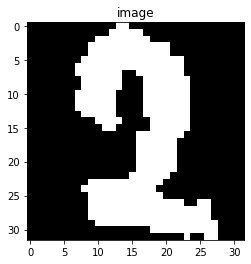

预测为： [9] 文件名为 ：  2_54.txt


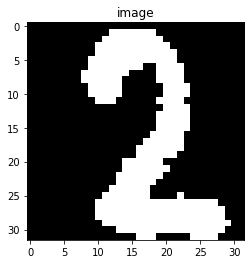

预测为： [9] 文件名为 ：  2_59.txt


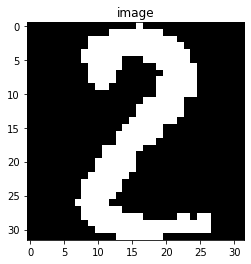

预测为： [9] 文件名为 ：  2_67.txt


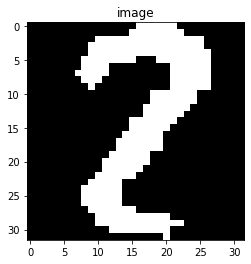

预测为： [3] 文件名为 ：  2_68.txt


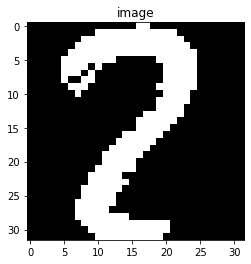

预测为： [7] 文件名为 ：  2_69.txt


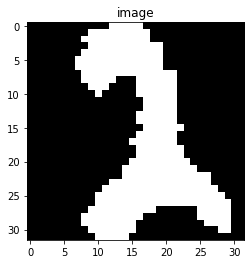

预测为： [3] 文件名为 ：  2_7.txt


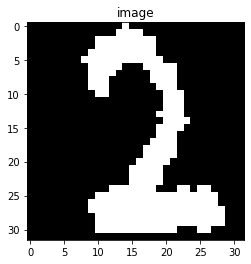

预测为： [3] 文件名为 ：  2_74.txt


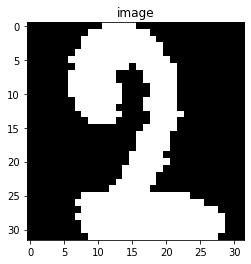

预测为： [1] 文件名为 ：  2_78.txt


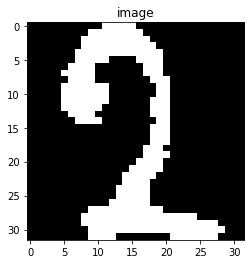

预测为： [1] 文件名为 ：  2_81.txt


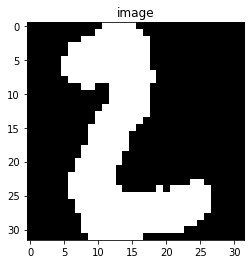

预测为： [6] 文件名为 ：  2_83.txt


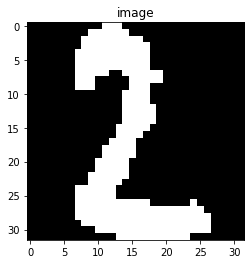

预测为： [3] 文件名为 ：  2_88.txt


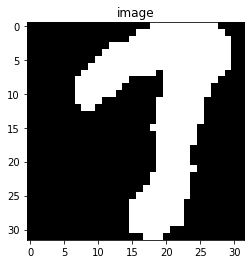

预测为： [9] 文件名为 ：  3_11.txt


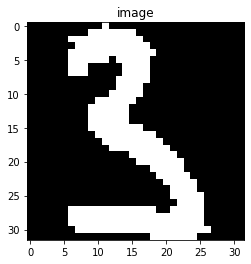

预测为： [1] 文件名为 ：  3_21.txt


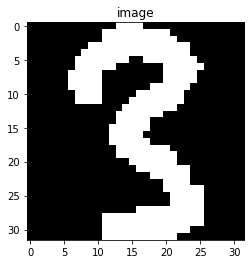

预测为： [9] 文件名为 ：  3_29.txt


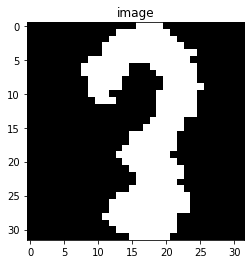

预测为： [9] 文件名为 ：  3_43.txt


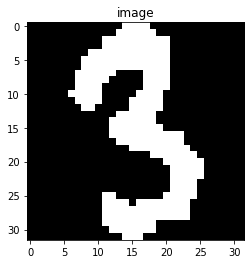

预测为： [5] 文件名为 ：  3_44.txt


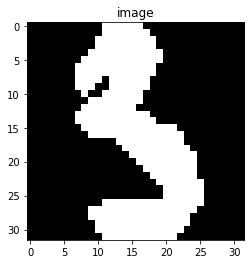

预测为： [5] 文件名为 ：  3_48.txt


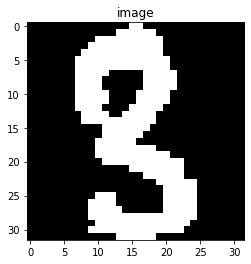

预测为： [5] 文件名为 ：  3_49.txt


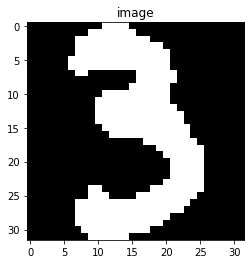

预测为： [5] 文件名为 ：  3_71.txt


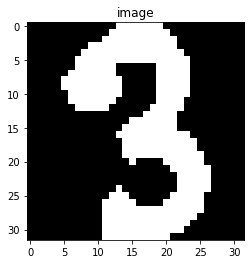

预测为： [9] 文件名为 ：  3_72.txt


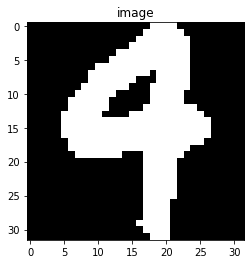

预测为： [9] 文件名为 ：  4_0.txt


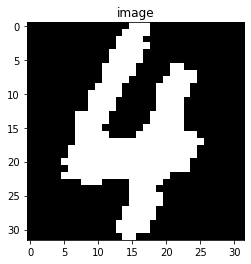

预测为： [7] 文件名为 ：  4_17.txt


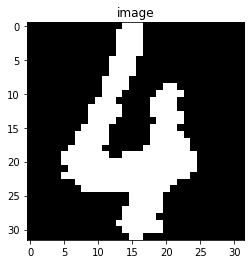

预测为： [8] 文件名为 ：  4_18.txt


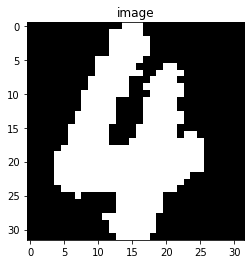

预测为： [8] 文件名为 ：  4_19.txt


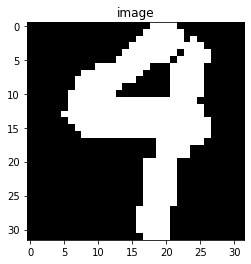

预测为： [9] 文件名为 ：  4_2.txt


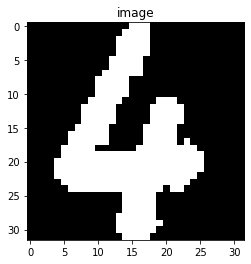

预测为： [8] 文件名为 ：  4_21.txt


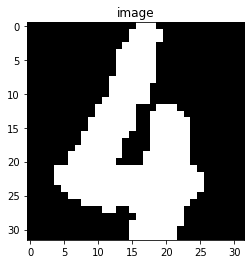

预测为： [6] 文件名为 ：  4_26.txt


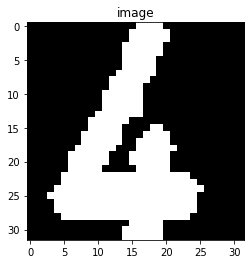

预测为： [6] 文件名为 ：  4_28.txt


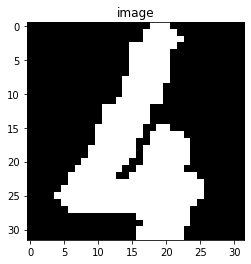

预测为： [1] 文件名为 ：  4_29.txt


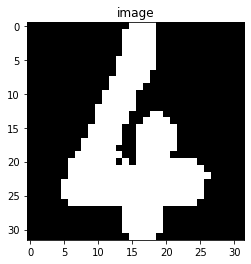

预测为： [6] 文件名为 ：  4_30.txt


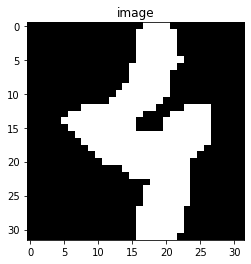

预测为： [3] 文件名为 ：  4_33.txt


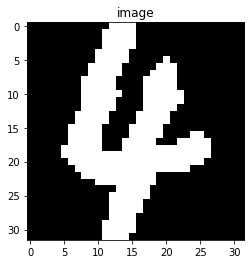

预测为： [7] 文件名为 ：  4_40.txt


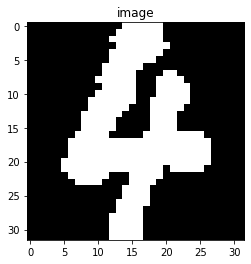

预测为： [8] 文件名为 ：  4_44.txt


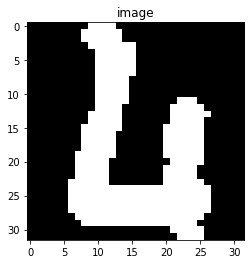

预测为： [0] 文件名为 ：  4_46.txt


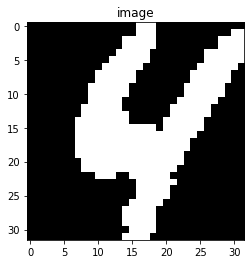

预测为： [0] 文件名为 ：  4_50.txt


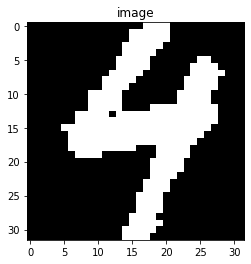

预测为： [9] 文件名为 ：  4_54.txt


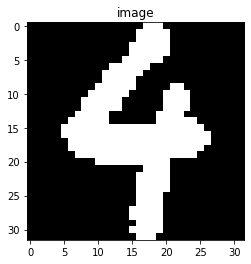

预测为： [9] 文件名为 ：  4_55.txt


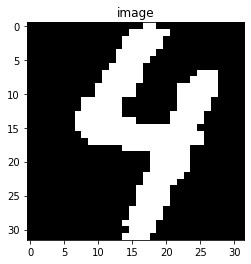

预测为： [9] 文件名为 ：  4_60.txt


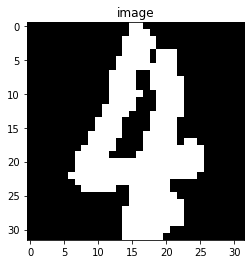

预测为： [8] 文件名为 ：  4_61.txt


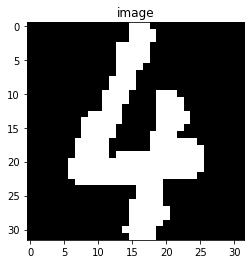

预测为： [8] 文件名为 ：  4_62.txt


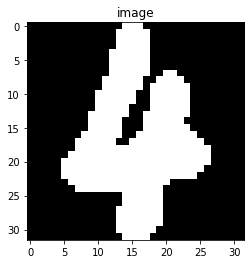

预测为： [1] 文件名为 ：  4_63.txt


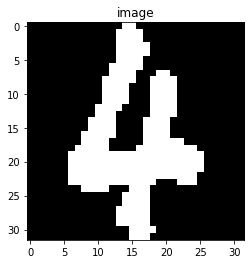

预测为： [8] 文件名为 ：  4_64.txt


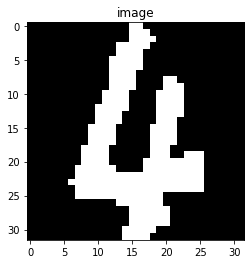

预测为： [8] 文件名为 ：  4_65.txt


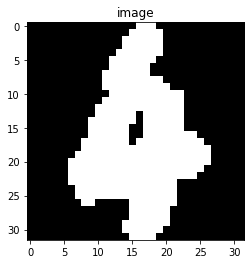

预测为： [1] 文件名为 ：  4_67.txt


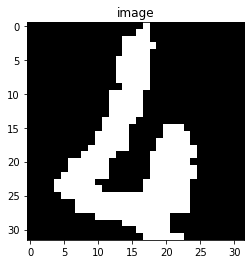

预测为： [6] 文件名为 ：  4_74.txt


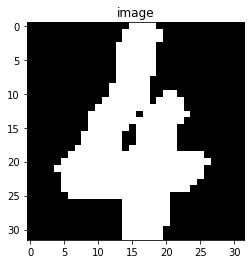

预测为： [1] 文件名为 ：  4_92.txt


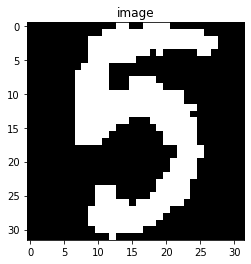

预测为： [9] 文件名为 ：  5_0.txt


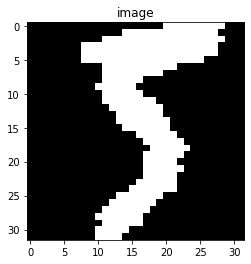

预测为： [9] 文件名为 ：  5_101.txt


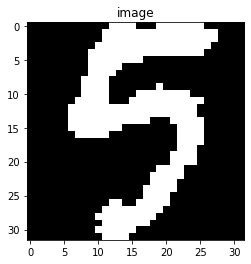

预测为： [9] 文件名为 ：  5_2.txt


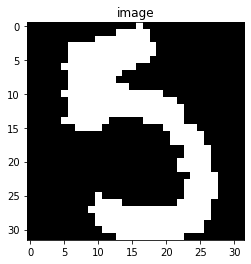

预测为： [1] 文件名为 ：  5_29.txt


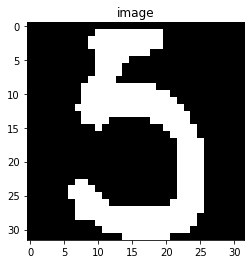

预测为： [4] 文件名为 ：  5_32.txt


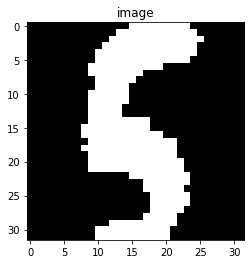

预测为： [4] 文件名为 ：  5_44.txt


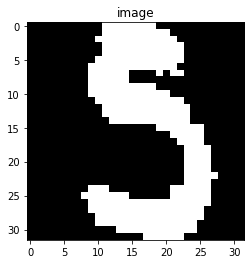

预测为： [4] 文件名为 ：  5_58.txt


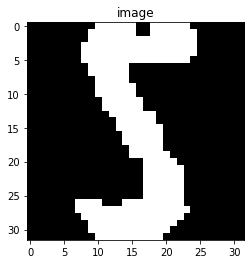

预测为： [3] 文件名为 ：  5_70.txt


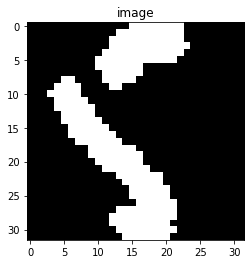

预测为： [2] 文件名为 ：  5_72.txt


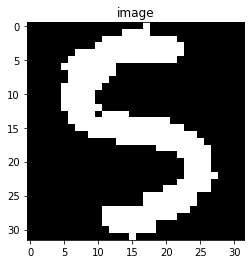

预测为： [3] 文件名为 ：  5_85.txt


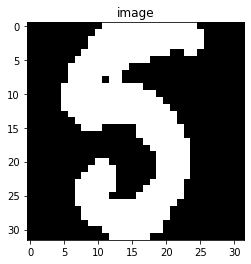

预测为： [0] 文件名为 ：  5_88.txt


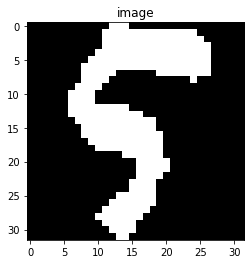

预测为： [7] 文件名为 ：  5_97.txt


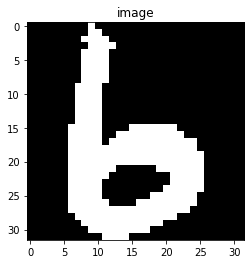

预测为： [8] 文件名为 ：  6_33.txt


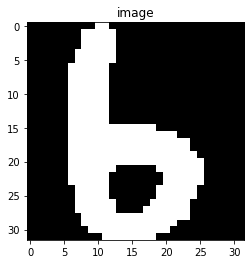

预测为： [2] 文件名为 ：  6_59.txt


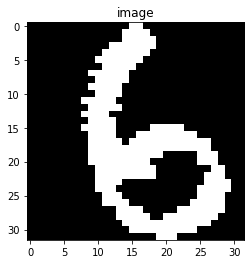

预测为： [1] 文件名为 ：  6_67.txt


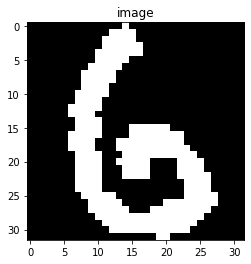

预测为： [8] 文件名为 ：  6_68.txt


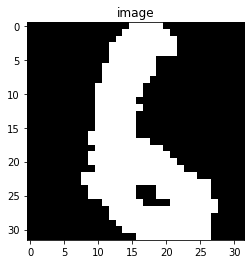

预测为： [5] 文件名为 ：  6_75.txt


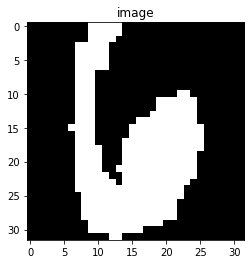

预测为： [8] 文件名为 ：  6_82.txt


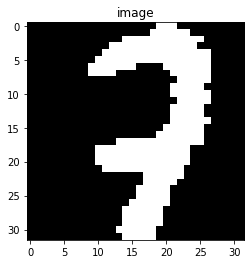

预测为： [3] 文件名为 ：  7_18.txt


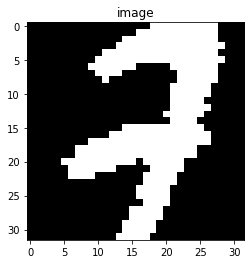

预测为： [4] 文件名为 ：  7_23.txt


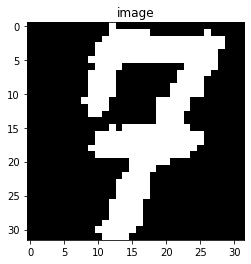

预测为： [9] 文件名为 ：  7_27.txt


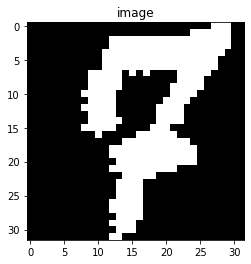

预测为： [8] 文件名为 ：  7_46.txt


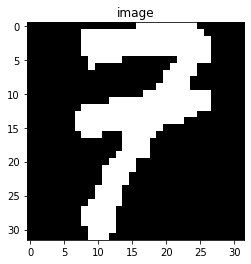

预测为： [5] 文件名为 ：  7_49.txt


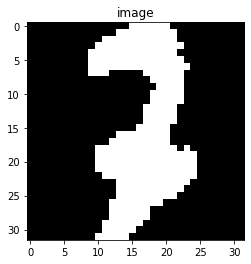

预测为： [1] 文件名为 ：  7_56.txt


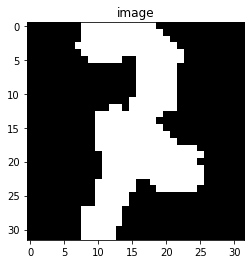

预测为： [1] 文件名为 ：  7_60.txt


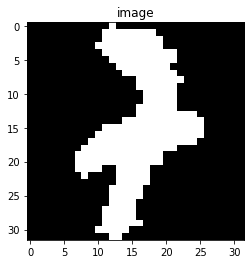

预测为： [8] 文件名为 ：  7_90.txt


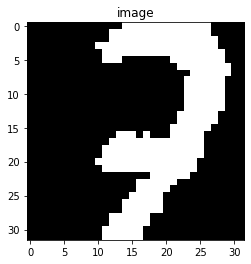

预测为： [5] 文件名为 ：  7_95.txt


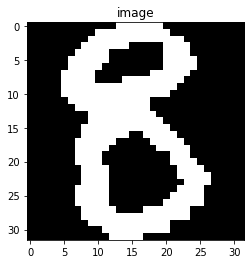

预测为： [2] 文件名为 ：  8_1.txt


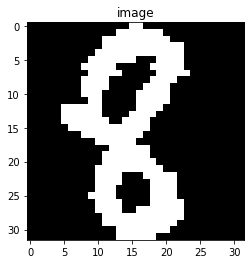

预测为： [5] 文件名为 ：  8_10.txt


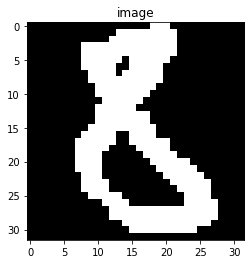

预测为： [4] 文件名为 ：  8_11.txt


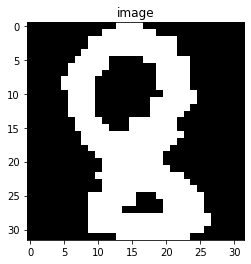

预测为： [2] 文件名为 ：  8_19.txt


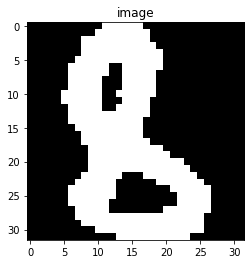

预测为： [2] 文件名为 ：  8_20.txt


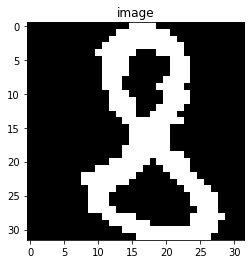

预测为： [7] 文件名为 ：  8_22.txt


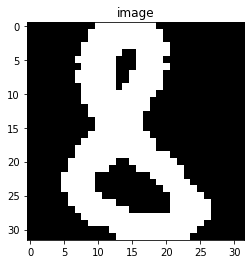

预测为： [2] 文件名为 ：  8_23.txt


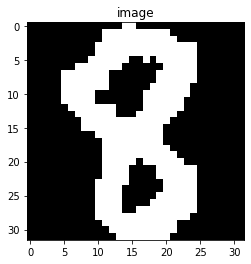

预测为： [2] 文件名为 ：  8_3.txt


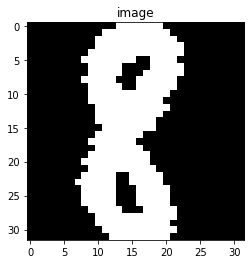

预测为： [1] 文件名为 ：  8_37.txt


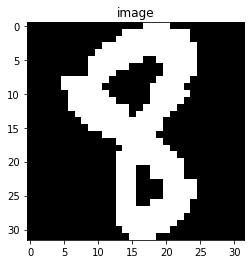

预测为： [9] 文件名为 ：  8_4.txt


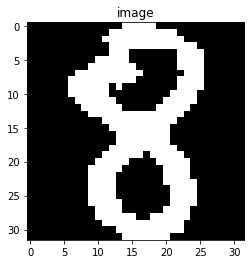

预测为： [6] 文件名为 ：  8_42.txt


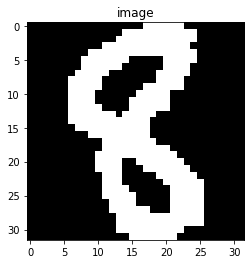

预测为： [3] 文件名为 ：  8_43.txt


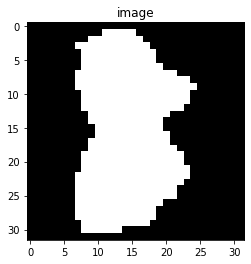

预测为： [1] 文件名为 ：  8_45.txt


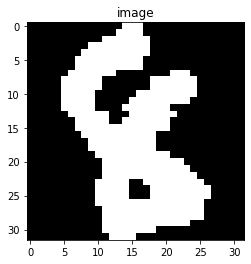

预测为： [2] 文件名为 ：  8_46.txt


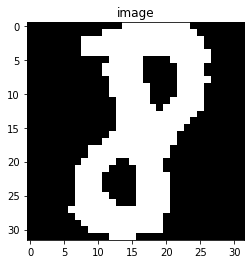

预测为： [6] 文件名为 ：  8_53.txt


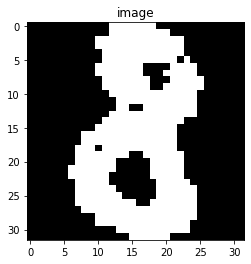

预测为： [2] 文件名为 ：  8_56.txt


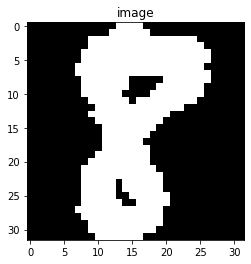

预测为： [1] 文件名为 ：  8_61.txt


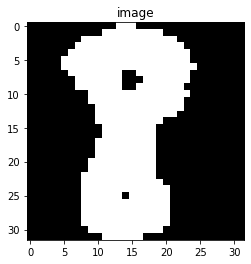

预测为： [1] 文件名为 ：  8_62.txt


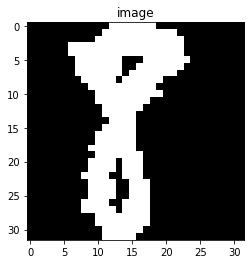

预测为： [6] 文件名为 ：  8_65.txt


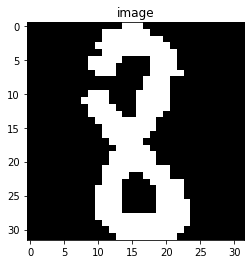

预测为： [5] 文件名为 ：  8_67.txt


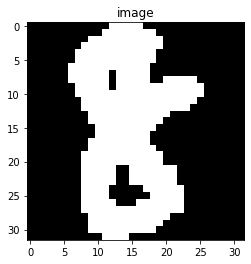

预测为： [1] 文件名为 ：  8_68.txt


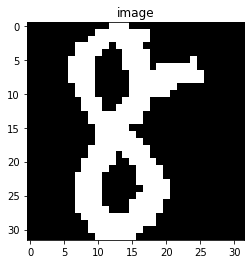

预测为： [4] 文件名为 ：  8_79.txt


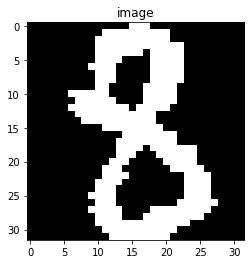

预测为： [1] 文件名为 ：  8_8.txt


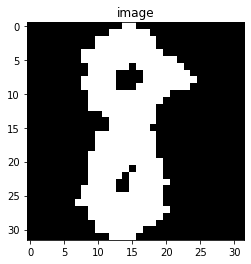

预测为： [1] 文件名为 ：  8_80.txt


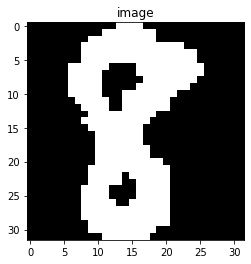

预测为： [1] 文件名为 ：  8_81.txt


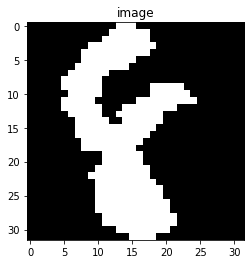

预测为： [2] 文件名为 ：  8_83.txt


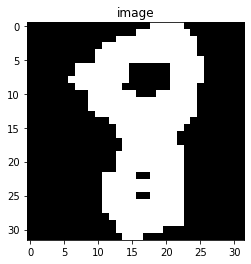

预测为： [9] 文件名为 ：  8_86.txt


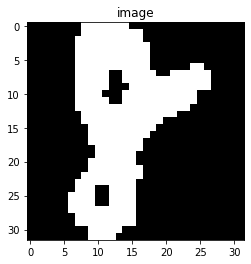

预测为： [1] 文件名为 ：  8_88.txt


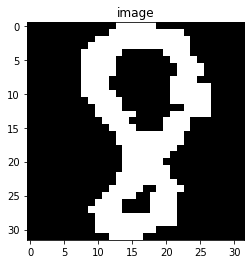

预测为： [9] 文件名为 ：  8_89.txt


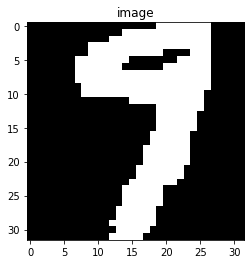

预测为： [7] 文件名为 ：  9_13.txt


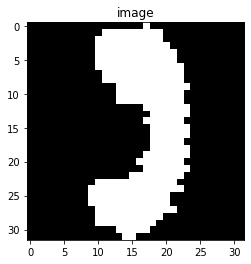

预测为： [2] 文件名为 ：  9_14.txt


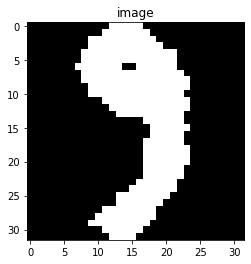

预测为： [7] 文件名为 ：  9_16.txt


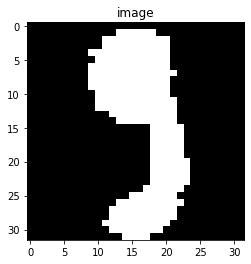

预测为： [1] 文件名为 ：  9_17.txt


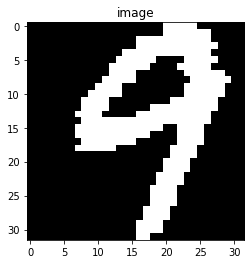

预测为： [5] 文件名为 ：  9_2.txt


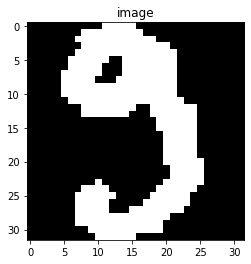

预测为： [5] 文件名为 ：  9_40.txt


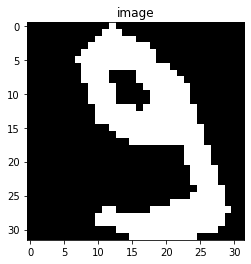

预测为： [2] 文件名为 ：  9_53.txt


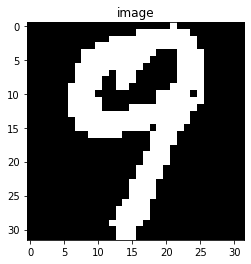

预测为： [4] 文件名为 ：  9_65.txt


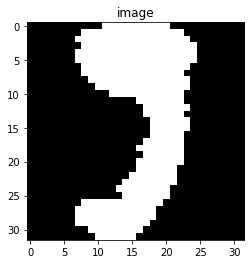

预测为： [7] 文件名为 ：  9_78.txt
总共错了150个数据
错误率为15.856237%


In [7]:
handwritingClassTestByCART()

## AdaBoost实现手写识别

In [8]:
'''
function : 返回手写识别的训练数据与训练标签
'''
def getTrainDataWithLabelForMutilClassifier():
    #训练集的Labels
    hwLabels = []
    #返回trainingDigits目录下的文件名
    trainingFileList = listdir('./KNN-master/trainingDigits')
    #返回文件夹下文件的个数
    m = len(trainingFileList)
    #初始化训练的Mat矩阵,训练集
    trainingMat = np.zeros((m, 1024))
    #从文件名中解析出训练集的类别
    for i in range(m):
        #获得文件的名字
        fileNameStr = trainingFileList[i]
        #获得分类的数字
        classNumber = int(fileNameStr.split('_')[0])
        #将获得的类别添加到hwLabels中
        trainingLabel = []
        for i in range(0, 10):
            if i == classNumber:
                trainingLabel.append(1)
            else:
                trainingLabel.append(-1)
        hwLabels.append(trainingLabel)
        #将每一个文件的1x1024数据存储到trainingMat矩阵中
        trainingMat[i,:] = img2vector('./KNN-master/trainingDigits/%s' % (fileNameStr))
    hwLabels = np.array(hwLabels)
    return trainingMat, hwLabels

In [21]:
"""
function :手写数字分类测试
"""
from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

def handwritingClassTestByAdaBoost():
    trainingMat, hwLabels = getTrainDataWithLabel()
    bdt_discrete = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),n_estimators=2000,   learning_rate=1.5, algorithm="SAMME")
    bdt_discrete.fit(trainingMat, hwLabels)
    ShowPredict(bdt_discrete)

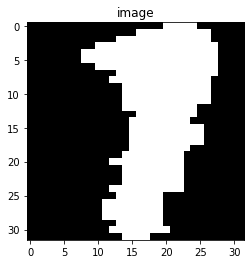

预测为： [7] 文件名为 ：  1_86.txt


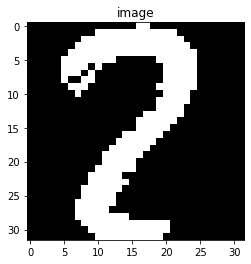

预测为： [8] 文件名为 ：  2_69.txt


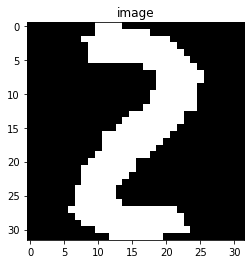

预测为： [8] 文件名为 ：  2_72.txt


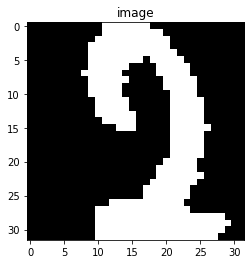

预测为： [9] 文件名为 ：  2_91.txt


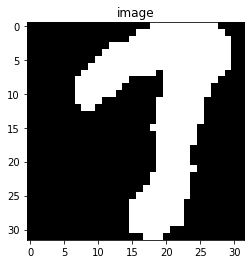

预测为： [9] 文件名为 ：  3_11.txt


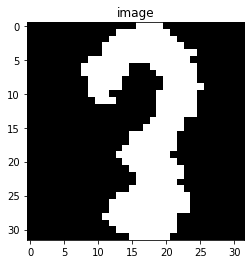

预测为： [9] 文件名为 ：  3_43.txt


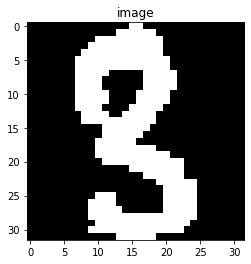

预测为： [8] 文件名为 ：  3_49.txt


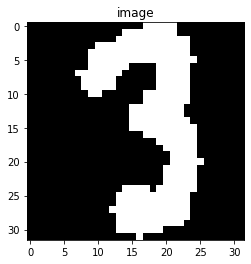

预测为： [9] 文件名为 ：  3_60.txt


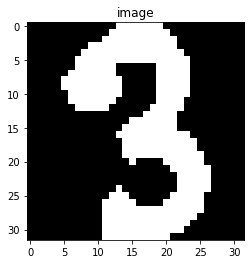

预测为： [9] 文件名为 ：  3_72.txt


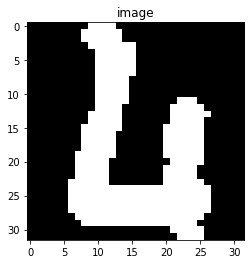

预测为： [0] 文件名为 ：  4_46.txt


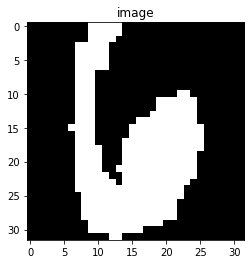

预测为： [4] 文件名为 ：  6_82.txt


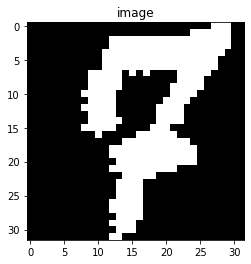

预测为： [9] 文件名为 ：  7_46.txt


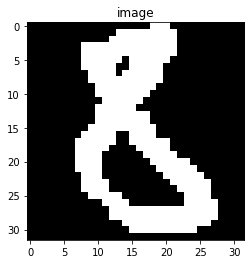

预测为： [6] 文件名为 ：  8_11.txt


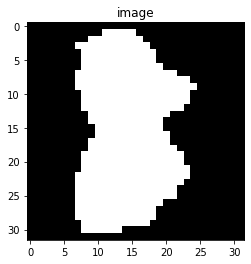

预测为： [1] 文件名为 ：  8_45.txt


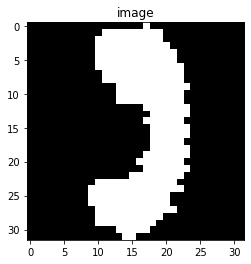

预测为： [1] 文件名为 ：  9_14.txt


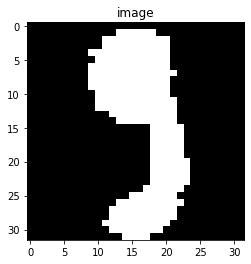

预测为： [1] 文件名为 ：  9_17.txt
总共错了16个数据
错误率为1.691332%


In [23]:
handwritingClassTestByAdaBoost()

### 结果统计与分析

|max_depth|n_estimators|error rate|
|:----:|:----:|:----:|
|1|1|81.606765%|
|1|600|8.985201%|
|1|1000|8.562368%|
|1|2000|8.456660%|

|max_depth|n_estimators|error rate|
|:----:|:----:|:----:|
|2|1|66.067653%|
|2|600|4.968288%|
|2|1000|3.911205%|
|2|2000|4.651163%|

|max_depth|n_estimators|error rate|
|:----:|:----:|:----:|
|3|1|37.632135%|
|3|600|3.911205%|
|3|1000|3.171247%|
|3|2000|3.382664%|

|max_depth|n_estimators|error rate|
|:----:|:----:|:----:|
|6|1|15.856237%|
|6|600|1.691332%|
|6|1000|1.585624%|
|6|2000|1.691332%|

- 弱分类器个数越多，则拟合程度越好，当然也越容易过拟合。
- 弱分类器的线性组合确实能够提升准确率
- 弱分类器的分类效果越好， 准确率也就越好

# 参考文献
[1] https://blog.csdn.net/asialee_bird/article/details/81051281?utm_source=app 

[2] 《统计学习方法》第 2 版，李航 

[3] https://zhuanlan.zhihu.com/p/67585925

[4] https://www.jianshu.com/p/514c07465a9e

[5] https://blog.csdn.net/hecongqing/article/details/104604111